In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

In [2]:
df_q = pd.read_excel('QUARTERLY_DATA.xlsx')
df_q = df_q[['Quarter/Year', 'Costuri cu materia prima RON']].dropna()
df_q['Quarter/Year'] = df_q['Quarter/Year'].astype(str).str.upper().str.strip()
def to_period(val):
    val = val.replace(' ', '')
    return val[-4:] + val[:2]
df_q['Quarter'] = pd.PeriodIndex(df_q['Quarter/Year'].apply(to_period), freq='Q')
df_q.set_index('Quarter', inplace=True)
df_q.rename(columns={'Costuri cu materia prima RON': 'Cost'}, inplace=True)

In [3]:
def process_comm(file, name):
    df = pd.read_excel(file, skiprows=6)[['Date', 'PX_LAST']].dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['PX_LAST']].resample('QE').mean()
    df.index = df.index.to_period('Q')
    df.rename(columns={'PX_LAST': name}, inplace=True)
    return df
df_pvc = process_comm('PVC (1).xlsx', 'PVC')
df_pe  = process_comm('1 (1).xlsx', 'PE')
df_pp  = process_comm('2 (1).xlsx', 'PP')

In [4]:
df_en = pd.read_csv('pret_energie_ro.csv')
df_en = df_en[df_en['ISO3 Code'] == 'ROU'].copy()
df_en['Date'] = pd.to_datetime(df_en['Date'], format='%d/%m/%Y')
df_en.set_index('Date', inplace=True)
df_en = df_en[['Price (EUR/MWhe)']].resample('QE').mean()
df_en.index = df_en.index.to_period('Q')
df_en.rename(columns={'Price (EUR/MWhe)': 'Energy'}, inplace=True)

In [5]:
df_merged = pd.concat(
    [df_q['Cost'], df_pvc, df_pe, df_pp, df_en],
    axis=1
).dropna()

In [6]:
variables = ['PVC', 'PE', 'PP', 'Energy']
for var in variables:
    df_merged[f'{var}_lag1'] = df_merged[var].shift(1)
df_merged = df_merged.dropna()

In [7]:
print("\n" + "=" * 60)
print("MULTICOLLINEARITY CHECK (VIF)")
print("=" * 60)
X_vif = sm.add_constant(df_merged[[f'{v}_lag1' for v in variables]])
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]
print(vif_data)


MULTICOLLINEARITY CHECK (VIF)
      Variable        VIF
0        const  34.626217
1     PVC_lag1   7.098806
2      PE_lag1   7.048561
3      PP_lag1   4.600525
4  Energy_lag1   2.550817


In [8]:
target = 'Cost'
lag_vars = [f'{v}_lag1' for v in variables]
X_multi = sm.add_constant(df_merged[lag_vars])
model_multi = sm.OLS(df_merged[target], X_multi).fit()
print("\n" + "=" * 60)
print("MULTIPLE REGRESSION WITH 1-QUARTER LAGS")
print("=" * 60)
print(model_multi.summary())


MULTIPLE REGRESSION WITH 1-QUARTER LAGS
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     8.102
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           8.51e-05
Time:                        20:36:09   Log-Likelihood:                -785.61
No. Observations:                  42   AIC:                             1581.
Df Residuals:                      37   BIC:                             1590.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const    

In [9]:
df_log = np.log(df_merged[[target] + lag_vars])
X_log = sm.add_constant(df_log[lag_vars])
model_log = sm.OLS(df_log[target], X_log).fit()
print("\n" + "=" * 60)
print("LOG-LOG MODEL (Elasticities)")
print("=" * 60)
print(model_log.summary())


LOG-LOG MODEL (Elasticities)
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     13.86
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           5.32e-07
Time:                        20:36:09   Log-Likelihood:                -1.7820
No. Observations:                  42   AIC:                             13.56
Df Residuals:                      37   BIC:                             22.25
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.83

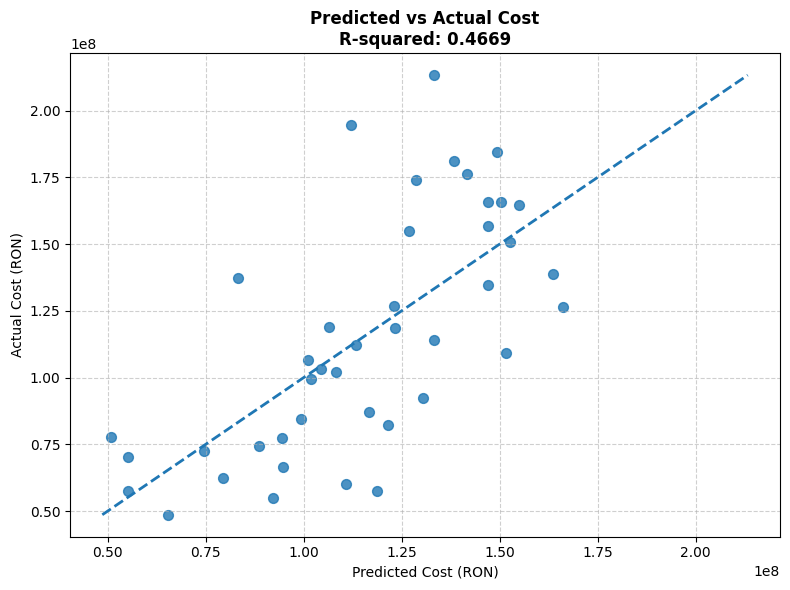

In [10]:
plt.figure(figsize=(8, 6))
predicted_cost = model_multi.predict(X_multi)
plt.scatter(predicted_cost,
            df_merged[target],
            alpha=0.8,
            s=50)
min_val = min(predicted_cost.min(), df_merged[target].min())
max_val = max(predicted_cost.max(), df_merged[target].max())
plt.plot([min_val, max_val],
         [min_val, max_val],
         linestyle='--',
         linewidth=2)
plt.title(f"Predicted vs Actual Cost\n"
          f"R-squared: {model_multi.rsquared:.4f}",
          fontweight='bold')
plt.xlabel('Predicted Cost (RON)')
plt.ylabel('Actual Cost (RON)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()